In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import requests

In [7]:
netflix = pd.read_csv('/Users/a91986/Downloads/netflix_titles.csv')
userNetflix = pd.read_csv('/Users/a91986/Downloads/rvhistory.csv')

In [9]:
netflix = netflix.drop(labels=['show_id', 'release_year', 'date_added', 'country'], axis=1)
movies = netflix[netflix['type'] == 'Movie']

<Axes: >

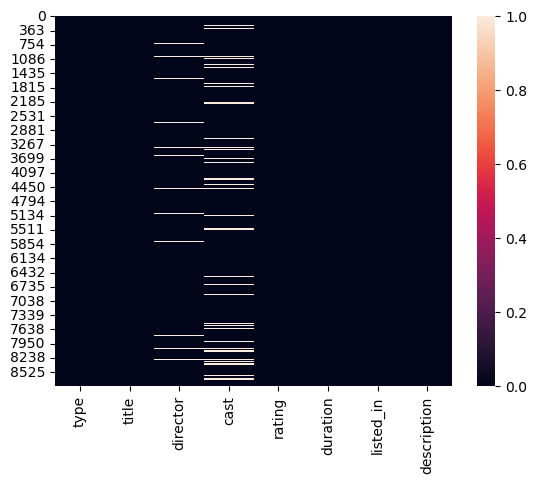

In [11]:
sns.heatmap(movies.isnull())

In [13]:
movies['cast'] = movies['cast'].fillna(' ')
movies['director'] = movies['director'].fillna(' ')

/var/folders/3g/9fbg7g1944x1q8kc6kx1nzfr0000gn/T/ipykernel_2545/2960859850.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['cast'] = movies['cast'].fillna(' ')
/var/folders/3g/9fbg7g1944x1q8kc6kx1nzfr0000gn/T/ipykernel_2545/2960859850.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['director'] = movies['director'].fillna(' ')


In [15]:
userMovies = movies[movies['title'].isin(userNetflix['Title'])]
userMovies.shape

(52, 8)

In [17]:
movies['text'] = (movies['title'] + ' ' + movies['listed_in'].fillna(' ') + ' ' + movies['director'] + ' ' + movies['description'].fillna(' '))
userMovies['text'] = (userMovies['title'] + ' ' + userMovies['listed_in'].fillna(' ') + ' ' + userMovies['director'] + ' ' + userMovies['description'].fillna(' '))

/var/folders/3g/9fbg7g1944x1q8kc6kx1nzfr0000gn/T/ipykernel_2545/3603630847.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['text'] = (movies['title'] + ' ' + movies['listed_in'].fillna(' ') + ' ' + movies['director'] + ' ' + movies['description'].fillna(' '))
/var/folders/3g/9fbg7g1944x1q8kc6kx1nzfr0000gn/T/ipykernel_2545/3603630847.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  userMovies['text'] = (userMovies['title'] + ' ' + userMovies['listed_in'].fillna(' ') + ' ' + userMovies['director

In [19]:
userMovies = userMovies.drop(['type', 'rating', 'duration'], axis=1)
movies = movies.drop(['type', 'rating', 'duration'], axis=1)

In [21]:
moviesRepeat = movies['title'].str.split('(').str[0]

In [23]:
movies.shape

(6131, 6)

In [25]:
movies = movies[movies['title'].isin(moviesRepeat)]

In [27]:
# Creating TF-IDF matrix
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(movies['text'])

In [29]:
user_watched_tfidf = vectorizer.transform(userMovies['text'])

In [31]:
user_movie_similarity = cosine_similarity(user_watched_tfidf, tfidf_matrix)

In [33]:
def findSimilarity() :
    movie_similarities = []
    for i in range(movies.shape[0]):
        movie_title = movies.iloc[i]['title']
        if movie_title not in userMovies['title'].values:
            max_similarity = user_movie_similarity[:, i].max()
            movie_similarities.append((movie_title, max_similarity))
    return movie_similarities

In [35]:
recommended_movies = sorted(findSimilarity(), key=lambda x: x[1], reverse=True)[:5]

In [42]:
api_key = 'b3bd4bfee63611ac2d1163f2474254af'
posters = []
def find_posters() :
    for movie_name, score in recommended_movies :
        response = requests.get(f'https://api.themoviedb.org/3/search/movie?query={movie_name}&api_key={api_key}')
        response_data = response.json()
        poster_path = response_data['results'][0]['poster_path']
        poster_url = f'https://image.tmdb.org/t/p/w500{poster_path}'
        posters.append(poster_url)
    return posters

In [44]:
movie_posters = find_posters()

In [46]:
print("Top 5 Movie Recommendations:")
for (title, score), poster in zip(recommended_movies, movie_posters):
    print(f"{title} -> {poster}")

Top 5 Movie Recommendations:
Petta -> https://image.tmdb.org/t/p/w500/yNkTNIjPl4QSQmVNQyfopM4wcFF.jpg
Andhaghaaram -> https://image.tmdb.org/t/p/w500/8sBXVEROEXoRaNEU8TYx26JZyeG.jpg
Ghost Stories -> https://image.tmdb.org/t/p/w500/7a0sai9k5jr7YJRP5S3YIDErMVY.jpg
Bombay Talkies -> https://image.tmdb.org/t/p/w500/jToHRUGY86MVkloVFgKVD090j90.jpg
ABCD 2 -> https://image.tmdb.org/t/p/w500/f7kAxvE8VXpOmeZZooPHkxhg3i0.jpg
